# **mRS outcomes** - extrapolation

In a previous notebook we showed how to generate distributions of probability of modified Rankin Scale (mRS) that vary with time, $P(\mathrm{mRS}, t)$, given two datasets: 

1. The mRS probability distribution at $t=0$.
2. The mRS probability distribution at $t=t_{\mathrm{ne}}$, the time of no effect.

For the example shown before, we considered the case of thrombectomy in which both of these data sets are available. 

However, the $t=0$ data is unknown for thrombolysis patients. For these patients, the available data is:

1. The mRS probability distribution at $t=t_{\mathrm{ne}}$.
2. The odds ratio of a good outcome for patients with a starting mRS$\leq$1 at $t=1\,$hr.
3. The mRS probability distribution pre-stroke, previously used as the prob. dist. _of thromectomy patients_ at $t=0$.

We will use these three data sets to define the mRS probability distribution at $t=0$. 

The steps are:
1. Define a straight line model for log(odds ratio), so that $\log(OR)=a+bt$ for a known $a$ and $b$ calculated from the $t=1\,$hr and $t=t_{\mathrm{ne}}$ data.
2. Extrapolate this line back to find log(odds ratio) at $t=0$ for mRS$\leq1$. 
3. Convert the log(odds ratio) at $t=0$ to probability $P(\mathrm{mRS}\leq1, t=0)$.
4. Use this new probability to define $t=0$ probabilities for the other mRS groups.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

---

## Collect the available data

Throughout this notebook, variable names contain the following strings:

+ `dist` - the mRS probability distributions.
+ `bins` - the cumulative mRS probabilities.
+ `t0_treatment` - treatment at time $t=0$.
+ `no_treatment` - treatment at the no-effect time $t=t_{\mathrm{ne}}$. 

### Gather data from the literature


1\. Time of no effect ($t_{\mathrm{ne}}$) distribution:

These data are copied over from `mRS_datasets.ipynb` and are measured from Lees et al. 2020 [1]. $P(\mathrm{mRS}=6)=0$.

[1] - insert ref here?

In [4]:
mrs_prob_dist_no_treatment = np.array([ 0.16841002, 0.2291431, 0.14193671, 0.15825232, 0.2046646, 0.09759325])
mrs_prob_bins_no_treatment = np.cumsum(mrs_prob_dist_no_treatment)

2\. Odds ratio for mRS$\leq1$ at $t=1\,$hr is $\sim1.9$, from Emberson et al. 2014 [2].

[2] _"Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: a meta-analysis of individual patient data from randomised trials"_

In [5]:
# OddsRatio_mRS<=1_time1hr: (leq = "less than or equal to")
OR_mRSleq1_t1 = 1.9

3\. Distribution of mRS pre-stroke, from the SAMueL-1 data set. $P(\mathrm{mRS}=6)=0$.

In [6]:
mrs_prob_dist_t0_treatment_pre = np.array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674, 0.0186443 ])
mrs_prob_bins_t0_treatment_pre = np.cumsum(mrs_prob_dist_t0_treatment_pre)

Define the no-effect time for thrombolysis, $t_{\mathrm{ne}}$:

In [7]:
t_ne = 6.3*60 # minutes

### Convert probability to odds ratio

From our input data, we know the values of $P(\mathrm{mRS}\leq x\ |\ t_{\mathrm{ne}})$ for a chosen mRS value of $x$. To directly compare these with the known odds ratio at $t=1\,$hr, it is easiest to convert the probabilities to odds ratio. Luckily, this is very simple for the case $t=t_{\mathrm{ne}}$. 

By definition, odds ratio $OR$ at a generic time $t$:

1: $$ OR(\mathrm{mRS},x,t) = \left\{ \frac{P(\mathrm{mRS}\leq x\ |\ t)}{P(\mathrm{mRS}>x\ |\ t)} \right\} \div \left\{ \frac{P(\mathrm{mRS}\leq x\ |\ t_{\mathrm{ne}})}{P(\mathrm{mRS}>x\ |\ t_{\mathrm{ne}})} \right\} $$

When $t=t_{\mathrm{ne}}$, the terms on the right-hand-side cancel out, leaving $OR(\mathrm{mRS}\leq x,t=t_{\mathrm{ne}})=1$ for all mRS. 

### Convert odds ratio to log(odds ratio)

We'll start the model in terms of log(odds ratio), $\log(OR)$, because we know that this can be modelled as a straight line. The conversion of odds ratio is straightforward:

+ $\log\bigl[OR(\mathrm{mRS}\leq 1\ |\ t=1\mathrm{hr})\bigr] = \log(1.9)$
+ $\log\bigl[OR(\mathrm{mRS}\leq x\ |\ t=t_{\mathrm{ne}})\bigr] = \log(1) = 0$ for all mRS

### Plot the available data

We'll plot the data in terms of log(odds ratio) and draw a straight line connecting the points.

Define x and y coordinates for the t=1hr and t=t_ne points:

In [8]:
x_t1  = 1*60                      # minutes
y_t1  = np.log(OR_mRSleq1_t1)     # from the data
x_tne = t_ne                      # minutes
y_tne = 0                         # by definition

Define some coordinates of the straight line connecting these two points:

In [9]:
# Find the step from the t=1 point to the t_ne point:
x_step = x_tne - x_t1
y_step = y_tne - y_t1

# Starting from the t=1hr point, step forwards and backwards in t:
x_line = [x_t1-x_step, x_t1+x_step]
y_line = [y_t1-y_step, y_t1+y_step]

Plot the data:

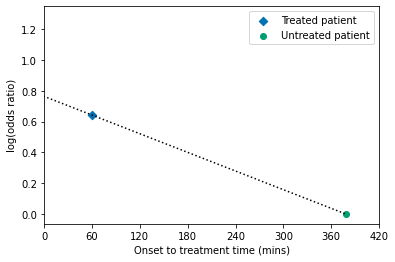

In [10]:
# Mark these two data points:
plt.scatter(x_t1,  y_t1,  label='Treated patient',   marker='D')
plt.scatter(x_tne, y_tne, label='Untreated patient', marker='o')

# Draw a straight line passing through the two points:
plt.plot(x_line,y_line, linestyle=':',color='k')

# Ọther plot setup:
plt.ylabel('log(odds ratio)')
plt.xlabel('Onset to treatment time (mins)')
plt.xlim(0,t_ne*1.1)
plt.xticks(np.arange(0,t_ne+60,60))
plt.legend()
plt.show()

---

## Step 1: Define a straight line model for log(odds ratio)

Here, we want to define log(OR) for mRS$\leq$1 at $t=0$.

We already have the following data points:

+ $ \log\bigl[OR(\mathrm{mRS}\leq 1, t=1\,\mathrm{hr})\bigr] = \log(1.9) $
+ $ \log\bigl[OR(\mathrm{mRS}\leq 1, t=t_{\mathrm{ne}})\bigr] = 0 $

We can connect these two points with a straight line, and then continue the line backwards in time to $t=0$ to find $\log(OR)$ for mRS$\leq$1 at $t=0$. 

We model log(odds ratio) as a straight line, $\log(OR)=a+bt$. 

At $t=t_{\mathrm{ne}}$,

$$
\begin{align}
\log\bigl[OR(\mathrm{mRS}\leq1, t=t_{\mathrm{ne}})\bigr] & = 0 \\
a+bt_{\mathrm{ne}} & = 0 \\
b & = -\frac{a}{t_{\mathrm{ne}}} \\
\end{align}
$$

Then at $t=1\,$hr,

$$
\begin{align}
\log\bigl[OR(\mathrm{mRS}\leq1, t=1\,\mathrm{hr})\bigr] & = \log(1.9) \\
a + b & = \log(1.9)  \\
a -\frac{a}{t_{\mathrm{ne}}} & = \log(1.9) \\
a\left(1 - \frac{1}{t_{\mathrm{ne}}}\right) & = \log(1.9) \\
a & = \frac{\log(1.9)}{1 - \frac{1}{t_{\mathrm{ne}}}} \\
\end{align}
$$

## Step 2: Extrapolate from $t=1\,$hr to $t=0\,$hr

Now that we've defined $a$ and $b$, we can use the same straight line equation to find the log(odds ratio) at $t=0$.

At $t=0$, the straight line $a+bt = a +0 = a $ and so:

2: $$ \log\bigl[OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\bigr] = a $$

### Calculate log(OR) for mRS$\leq$1 at $t=0$

> Note that $t_{\mathrm{ne}}$ should be given in _hours_ here, because we've already included the unit of hours in $t=1\,$hr, and setting $t=1$ (hr) instead of $t=60$ (minutes) was essential for the formulation of $a$.

In [11]:
a = np.log(OR_mRSleq1_t1) / (1.0 - (t_ne/60.0)**(-1.0))

a

0.7629583929973748

In [12]:
logOR_mRSleq1_t0 = a

### Plot the new value

We can compare the newly-calculated log(OR) value with the plot from before:

In [13]:
# Define x and y coordinates of the t=0 point:
x_t0 = 0
y_t0 = logOR_mRSleq1_t0

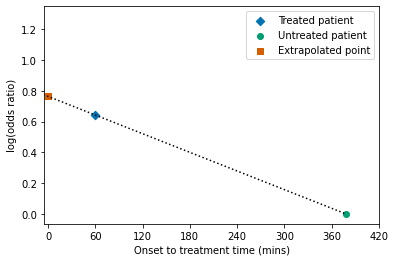

In [14]:
# Mark the data points:
plt.scatter(x_t1,  y_t1,  label='Treated patient',    marker='D')
plt.scatter(x_tne, y_tne, label='Untreated patient',  marker='o')
plt.scatter(x_t0,  y_t0,  label='Extrapolated point', marker='s')

# Draw a straight line connecting the two points:
plt.plot(x_line, y_line, linestyle=':',color='k')

# Ọther plot setup:
plt.ylabel('log(odds ratio)')
plt.xlabel('Onset to treatment time (mins)')
plt.xlim(-5,t_ne*1.1)
plt.xticks(np.arange(0,t_ne+60,60))
plt.legend()
plt.show()

## Step 3: Convert this log(OR) to probability

Now that we know the log(odds ratio) at $t=0$, we can convert it into probability. From the definition of odds ratio (Equation 1):

3: $$ \frac{P(\mathrm{mRS}\leq 1\ |\ t=0)}{P(\mathrm{mRS}>1\ |\ t=0)}  = OR(\mathrm{mRS}\leq1,t=0) \cdot \left\{ \frac{P(\mathrm{mRS}\leq 1\ |\ t_{\mathrm{ne}})}{P(\mathrm{mRS}>1\ |\ t_{\mathrm{ne}})} \right\} $$

We now know all of the terms on the right hand side. The probability terms are known from the literature data, and from Equation 2:

$$
\begin{align}
    \log\bigl[OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\bigr] & = a \\
    OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\phantom{\bigr]} & = e^a \\
\end{align}
$$

To rearrange Equation 3 in the form $ P(\mathrm{mRS}\leq 1\ |\ t=0) = ... $, we'll set $P=P(\mathrm{mRS}\leq 1\ |\ t=0)$ and set the entire right-hand-side of the equation to a new constant $R$:

$$
\begin{align}
\frac{P}{1 - P}  & = R \\
P & = R(1-P) \\
P + (P\cdot R) & = R \\
P(1 + R) & = R \\
P & = \frac{R}{1 + R} \\
\end{align}
$$

This is ugly to write out in full, so we define $P_R = P(\mathrm{mRS}\leq 1\ |\ t_{\mathrm{ne}})$ and use $OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\phantom{\bigr]} = e^a $ so that:

4: $$ P(\mathrm{mRS}\leq 1\ |\ t=0) = \frac{e^{a} \cdot \left\{ \frac{P_{R}}{1 - P_{R}} \right\}}{1 + e^{a} \cdot \left\{ \frac{P_{R}}{1 - P_{R}} \right\}} $$

### Calculate this $P(\mathrm{mRS}\leq 1\ |\ t=0)$

In [15]:
# Probability of mRS<=1 at t=t_ne (a.k.a. probability P_R):
p_mRSleq1_tne = mrs_prob_bins_no_treatment[1]

p_mRSleq1_tne

0.39755312

Calculate $R$, the right-hand-side of Equation 3.

In [16]:
R = np.exp(a) * p_mRSleq1_tne / (1 - p_mRSleq1_tne)

Calculate $P(\mathrm{mRS}\leq 1\ |\ t=0)$ using Equation 4:

In [17]:
p_mRSleq1_t0 = R / (1 + R)

p_mRSleq1_t0

0.5859596403377257

### Plot our known probabilities

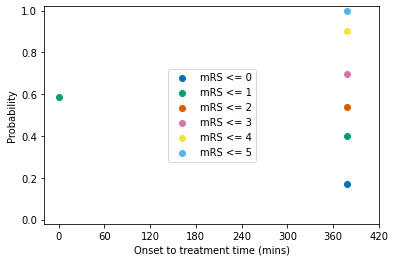

In [18]:
# t_ne data:
for i in range(6):
    s = plt.scatter(t_ne, mrs_prob_bins_no_treatment[i], label=f'mRS <= {i}')
    if i ==1:
        # Store the colour of mRS<=1. Use it later for the t=0 point.
        colour = s.get_facecolor()

# Newly-found t=0 data:
plt.scatter(0, p_mRSleq1_t0, color=colour)
    
# Usual plot setup:
plt.ylabel('Probability')
plt.xlabel('Onset to treatment time (mins)')
plt.xticks(np.arange(0,t_ne+60,60))
plt.ylim(-0.02,1.02)
plt.legend(loc='center')
plt.show()

## Step 4: Scale the existing $t=0$ probability distribution for all mRS

Currently we only know one point of the $t=0$ probability distribution, which is the $P(\mathrm{mRS}\leq 1\ |\ t=0)$ that we've just calculated. We will need to expand on this point to create a probability distribution at $t=0$ for all mRS, not just mRS$\leq$1. 

We will base the new distribution on some existing data. In this case, we will use the mRS probability distribution pre-stroke, i.e. at the time just before the onset of stroke. 

### Plot the existing probability distributions:

Since we don't need the time axis from the previous plots, we will plot these probability distributions as a horizontal bar chart.

Define a function so that we can plot the same bars in multiple figures:

In [19]:
def draw_horizontal_bars(dist,label=''):
    """
    Draw a stacked horizontal bar chart of the values in 'dist'.
    
    dist  - list or np.array. The probability distribution 
            (non-cumulative).
    label - string. The name printed next to these stacked bars,
    """
    # The first bar will start at this point on the x-axis:
    left = 0
    for i in range(len(dist)):
        # Draw a bar starting from 'left', the end of the previous bar,
        # with a width equal to the probability of this mRS:
        plt.barh(label, width=dist[i], 
                 left=left, height=0.3, label=f'mRS={i}')
        # Update 'left' with the width of the current bar so that the next
        # bar drawn will start in the correct place.    
        left += dist[i]

In [20]:
def draw_horizontal_arrow(x_left,x_right,y,label=''):
    """
    Draw an arrow <-> with a label above it.
    
    x_left, x_right, y - float or int. The coordinates of the arrow.
    label              - string. Optional label to add above the arrow.
    """
    # Draw a horizontal arrow between 0 and the mRS<=1 line:
    plt.annotate('', xy=(x_left,y), xytext=(x_right,y),
                 arrowprops=dict(arrowstyle='<->'))
    # and add a label for the arrow:
    plt.annotate(label, xy=(0.5*(x_left+x_right),y+0.1), ha='center')

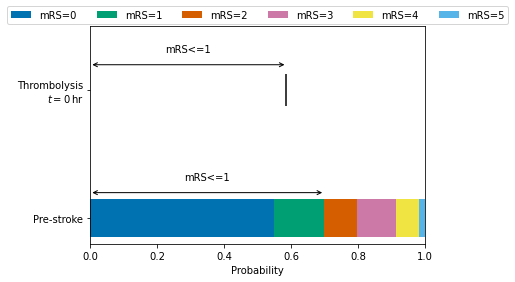

In [21]:
# Draw the pre-stroke distribution: 
draw_horizontal_bars(mrs_prob_dist_t0_treatment_pre, 'Pre-stroke')
# Add legend now to prevent doubling all the labels:
plt.legend(loc='center',ncol=6, 
           bbox_to_anchor=[0.5,1.0,0.0,0.1])   # Legend above axis.

# Set up an empty bar for the t=0 distribution:
draw_horizontal_bars([0.0],  'Thrombolysis'+'\n'+r'$t=0\,$hr')
# Draw a vertical line where mRS<=1:
plt.scatter(p_mRSleq1_t0, 1.0, marker='|', color='k', s=1000)

# Annotate where mRS<=1.
draw_horizontal_arrow(0.0, p_mRSleq1_t0,
                      y=1.2,label='mRS<=1')
draw_horizontal_arrow(0.0, mrs_prob_bins_t0_treatment_pre[1],
                      y=0.2,label='mRS<=1')


# Other setup:
plt.xlabel('Probability')
plt.xlim(0,1)
plt.ylim(-0.2,1.5)       
plt.show()

The point where mRS$\leq$1 is different in each of the distributions. 

### The scaling method

To create the new $t=0$ distribution, we initially want to set $P(\mathrm{mRS}\leq 1, t=0)$ to the newly-calculated value. To find the other mRS values, we start with the pre-stroke bins only and find the size ratio of each mRS bin to the mRS$\leq1$ bin. By carrying the ratios over to the new $t=0$ distribution, we can define the new points.

For example:
+ The pre-stroke mRS<=1 area $G_P$ covers only mRS=0 and mRS=1. 
+ The pre-stroke mRS=0 bin covers some known percentage $G_{P0}$% of the full area $G_P$. 
+ We set the $t=0$ mRS=0 bin to be $G_{P0}$% of the size of the $t=0$ mRS$\leq1$ bin, $G$.

For mRS>1, we instead keep the same size ratio of each bin to the mRS>1 bin. 

### Calculate the scaled $t=0$ distribution:

In [22]:
def get_scaled_dist(mrs_prob_bins,p_ref,mRS_ref):
    """
    Scale an existing probability distribution to a new data point.
    
    Inputs:
    mrs_prob_bins - list or np.array. Prob. dist to be scaled.
    p_ref         - float. Reference probability.
    mRS_ref       - int. The mRS bin of this reference probability. 
    
    Returns:.
    mrs_prob_dist_sc - np.array. Prob. dist after scaling.
    mrs_prob_bins_sc - np.array. Cumulative prob. dist after scaling.
    """
    # Store the scaled bins in mrs_prob_bins_sc:    
    mrs_prob_bins_sc = np.zeros_like(mrs_prob_bins)
    
    for mRS in range(6):
        if mRS<=mRS_ref:
            # For the points below the new reference p_ref.
            # Find the size ratio of this bin to the mRS<=mRS_ref bin.
            # When mRS=mRS_ref, ratio=1.
            ratio = mrs_prob_bins[mRS] / mrs_prob_bins[mRS_ref]
            # Scale the bins:
            mrs_prob_bins_sc[mRS] = p_ref * ratio
        else:
            # For the points above the new reference p_ref.
            # Find the size ratio of this bin excluding mRS<=mRS_ref,
            # with size (mrs_prob_bins[mRS]-mrs_prob_bins[mRS_ref]),
            # to the mRS>mRS_ref bin,
            # with size (1-mrs_prob_bins[mRS_ref]).
            ratio = ((mrs_prob_bins[mRS] - mrs_prob_bins[mRS_ref]) /
                     (1 - mrs_prob_bins[mRS_ref]))
            # Scale the bins:
            mrs_prob_bins_sc[mRS] =  p_ref + (1-p_ref)*ratio
    
    # Use bins to obtain distribution
    mrs_prob_dist_sc = np.diff(np.concatenate(([0.0],mrs_prob_bins_sc)))
    
    return mrs_prob_dist_sc, mrs_prob_bins_sc

In [23]:
mrs_prob_dist_t0_treatment, mrs_prob_bins_t0_treatment = (
    get_scaled_dist(mrs_prob_bins_t0_treatment_pre,p_mRSleq1_t0,mRS_ref=1))

In [24]:
mrs_prob_dist_t0_treatment

array([0.46101001, 0.12494963, 0.1346828 , 0.16163172, 0.09212051,
       0.02560534])

In [25]:
mrs_prob_bins_t0_treatment

array([0.46101001, 0.58595964, 0.72064244, 0.88227417, 0.97439468,
       1.00000001])

### Plot the two distributions:

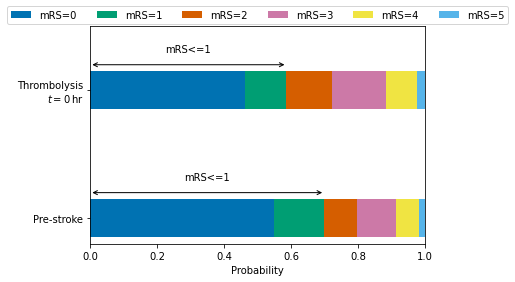

In [26]:
# Draw the pre-stroke distribution: 
draw_horizontal_bars(mrs_prob_dist_t0_treatment_pre, 'Pre-stroke')
# Add legend now to prevent doubling all the labels:
plt.legend(loc='center',ncol=6, 
           bbox_to_anchor=[0.5,1.0,0.0,0.1])   # Legend above axis.

# Draw the t=0 distribution:
draw_horizontal_bars(mrs_prob_dist_t0_treatment,  
                     'Thrombolysis'+'\n'+r'$t=0\,$hr')

# Annotate where mRS<=1.
draw_horizontal_arrow(0.0, p_mRSleq1_t0,
                      y=1.2,label='mRS<=1')
draw_horizontal_arrow(0.0, mrs_prob_bins_t0_treatment_pre[1],
                      y=0.2,label='mRS<=1')


# Other setup:
plt.xlabel('Probability')
plt.xlim(0,1)
plt.ylim(-0.2,1.5)       
plt.show()

Print the relevant size ratios of the bins.

In [27]:
print('       | ------------Pre-stroke------------- |')
print('       | Bin width | Ref. bin width | Ratio  |')
print('----------------------------------------------')
for i in range(6):
    p_pre = mrs_prob_dist_t0_treatment_pre[i]
    
    if i<2:
        p_ref_pre = mrs_prob_bins_t0_treatment_pre[1]
    else:
        p_ref_pre = 1.0 - mrs_prob_bins_t0_treatment_pre[1]
        
    ratio_pre = p_pre / p_ref_pre
    
    print(f'mRS={i}: |   {p_pre:1.3f}   |      {p_ref_pre:1.3f}     | {ratio_pre:1.4f} |')

print(' ')
print('       | ----------------t=0---------------- |')
print('       | Bin width | Ref. bin width | Ratio  |')
print('---------------------------------------------')
for i in range(6):
    p_t0  = mrs_prob_dist_t0_treatment[i] 
    
    if i<2:
        p_ref_t0  = p_mRSleq1_t0
    else:
        p_ref_t0  = 1.0 - p_mRSleq1_t0
        
    ratio_t0  = p_t0  / p_ref_t0
    
    print(f'mRS={i}: |   {p_t0:1.3f}   |      {p_ref_t0:1.3f}     | {ratio_t0:1.4f} |')

       | ------------Pre-stroke------------- |
       | Bin width | Ref. bin width | Ratio  |
----------------------------------------------
mRS=0: |   0.550   |      0.699     | 0.7868 |
mRS=1: |   0.149   |      0.699     | 0.2132 |
mRS=2: |   0.098   |      0.301     | 0.3253 |
mRS=3: |   0.118   |      0.301     | 0.3904 |
mRS=4: |   0.067   |      0.301     | 0.2225 |
mRS=5: |   0.019   |      0.301     | 0.0618 |
 
       | ----------------t=0---------------- |
       | Bin width | Ref. bin width | Ratio  |
---------------------------------------------
mRS=0: |   0.461   |      0.586     | 0.7868 |
mRS=1: |   0.125   |      0.586     | 0.2132 |
mRS=2: |   0.135   |      0.414     | 0.3253 |
mRS=3: |   0.162   |      0.414     | 0.3904 |
mRS=4: |   0.092   |      0.414     | 0.2225 |
mRS=5: |   0.026   |      0.414     | 0.0618 |


So the mRS=0 bin covers 78.68% of the mRS$\leq$1 bin in the original pre-stroke distribution, and the new scaled $t=0$ keeps this size ratio. 

> Each column of ratios adds up to 2 rather than 1. This is because we consider the ratio of the bins to two different areas: the mRS$\leq$1 area, and the mRS>1 area. The ratios for mRS=0 and mRS=1 add up to 1 as they span the full mRS$\leq$1 area, and separately the remaining mRS>1 ratios add up to 1 as they span everything else.

The newly-defined $t=0$ probability distribution can now be used in the outcome modelling as normal. 